In [1]:
import numpy as np
import h5py
import ppsci
import paddle
from paddle import nn

from ppsci.utils import logger
from matplotlib import pyplot as plt

from TopOptModel import TopOptNN
from data_utils import augmentation
from prepare_datasets import generate_train_test

In [2]:
ppsci.utils.set_random_seed(42)

OUTPUT_DIR = "./Outputs/results"
DATA_PATH = "./Dataset/PreparedData/top_dataset.h5"

BATCH_SIZE = 32
N_SAMPLE = 10000
TRAIN_TEST_RATIO = 1.0
VOL_COEFF = 1

logger.init_logger("ppsci", f"{OUTPUT_DIR}/results.log", "info")

In [3]:

X_data, Y_data = generate_train_test(DATA_PATH, TRAIN_TEST_RATIO, N_SAMPLE)

In [4]:
iterations = range(5, 85, 5)
model = TopOptNN()

In [5]:
def loss_expr(output_dict, label_dict, weight_dict=None):
    y = label_dict["output"].reshape((-1, 1))
    y_pred = output_dict["output"].reshape((-1, 1))
    conf_loss = paddle.mean(
        nn.functional.log_loss(y_pred, y, epsilon=1e-7)
    )  # epsilon = 1e-07 is the default in tf
    vol_loss = paddle.square(paddle.mean(y - y_pred))
    return conf_loss + VOL_COEFF * vol_loss

In [6]:
sup_constraint = ppsci.constraint.SupervisedConstraint(
        {
            "dataset": {
                "name": "NamedArrayDataset",
                "input": {"input": X_data},
                "label": {"output": Y_data},
            },
            "batch_size": BATCH_SIZE,
            "sampler": {
                "name": "BatchSampler",
                "drop_last": False,
                "shuffle": True,
            },
            "transforms": (
                {
                    "FunctionalTransform": {
                        "transform_func": augmentation,
                    },
                },
            ),
        },
        ppsci.loss.FunctionalLoss(loss_expr),
        name="sup_constraint",
    )

d:\PaddleScience_Project\paddle_env\lib\site-packages\paddle\io\reader.py:433: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [7]:
def metric_expr(output_dict, label_dict, weight_dict = None):
    output = output_dict["output"]
    y = label_dict["output"]
    accurates = paddle.equal(paddle.round(y), paddle.round(output))
    acc = paddle.mean(paddle.cast(accurates, dtype='float32'))
    w00 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 0.), paddle.equal(paddle.round(y), 0.))), dtype="float32")
    w11 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 1.), paddle.equal(paddle.round(y), 1.))), dtype="float32")
    w01 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 1.), paddle.equal(paddle.round(y), 0.))), dtype="float32")
    w10 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 0.), paddle.equal(paddle.round(y), 1.))), dtype="float32")
    n0 = paddle.add(w01, w00)
    n1 = paddle.add(w11, w10)
    iou = 0.5 * paddle.add(
        paddle.divide(w00, paddle.add(n0, w10)),
        paddle.divide(w11, paddle.add(n1, w01))
    )
    return {
        "Binary_Acc": acc,
        "IoU": iou
    }

In [8]:
num_val_step = 10
acc_results_summary = {}
iou_results_summary = {}
model_list = ['Poisson5', 'Poisson10', 'Poisson30', 'Uniform']
for model_name in model_list:
    solver = ppsci.solver.Solver(
        model,
        pretrained_model_path= "./Outputs/"+ model_name +"_vol_coeff1/checkpoints/latest"
    )
    acc_results = []
    iou_results = []
    for stop_iter in iterations:
        SIMP_stop_point_sampler = lambda: stop_iter
        solver.model.channel_sampler = SIMP_stop_point_sampler
        
        total_val_steps = 0
        current_acc_results = []
        current_iou_results = []

        for x, y, _ in iter(sup_constraint.data_loader):
            if total_val_steps >= num_val_step:
                break
            out = solver.predict(x, batch_size=BATCH_SIZE)
            metric = metric_expr(out, y)
            current_acc_results.append(np.array(metric['Binary_Acc']))
            current_iou_results.append(np.array(metric['IoU']))
            total_val_steps += 1

        acc_results.append(np.mean(current_acc_results))
        iou_results.append(np.mean(current_iou_results))
    
    acc_results_summary[model_name] = acc_results
    iou_results_summary[model_name] = iou_results

[2023/10/23 18:44:28] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson5_vol_coeff1/checkpoints/latest
[2023/10/23 18:44:28] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/23 18:44:28] ppsci INFO: Set to_static=False for forward computation.


[2023/10/23 18:44:46] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson10_vol_coeff1/checkpoints/latest
[2023/10/23 18:44:46] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/23 18:44:46] ppsci INFO: Set to_static=False for forward computation.
[2023/10/23 18:45:01] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson30_vol_coeff1/checkpoints/latest
[2023/10/23 18:45:01] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/23 18:45:01] ppsci INFO: Set to_static=False for forward computation.
[2023/10/23 18:45:17] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Uniform_vol_coeff1/checkpoints/latest
[2023/10/23 18:45:17] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/23 18:45:17] ppsci INFO: Set to_static=False for forward computation.


In [9]:
th_acc_results = []
th_iou_results = []
for stop_iter in iterations:
    SIMP_stop_point_sampler = lambda: stop_iter
    
    total_val_steps = 0
    current_acc_results = []
    current_iou_results = []

    for x, y, _ in iter(sup_constraint.data_loader):
        if total_val_steps >= num_val_step:
            break

        # thresholding
        k = SIMP_stop_point_sampler()
        x1 = x['input'][:, k, :, :]
        x2 = x['input'][:, k - 1, :, :]
        x = paddle.stack((x1, x1 - x2), axis=1)
        out = paddle.cast(x[:,0:1,:,:] > 0.5, dtype="float32")
        metric = metric_expr({'output': out}, y)
        current_acc_results.append(np.array(metric['Binary_Acc']))
        current_iou_results.append(np.array(metric['IoU']))
        total_val_steps += 1

    th_acc_results.append(np.mean(current_acc_results))
    th_iou_results.append(np.mean(current_iou_results))
    
acc_results_summary['thresholding'] = th_acc_results
iou_results_summary['thresholding'] = th_iou_results

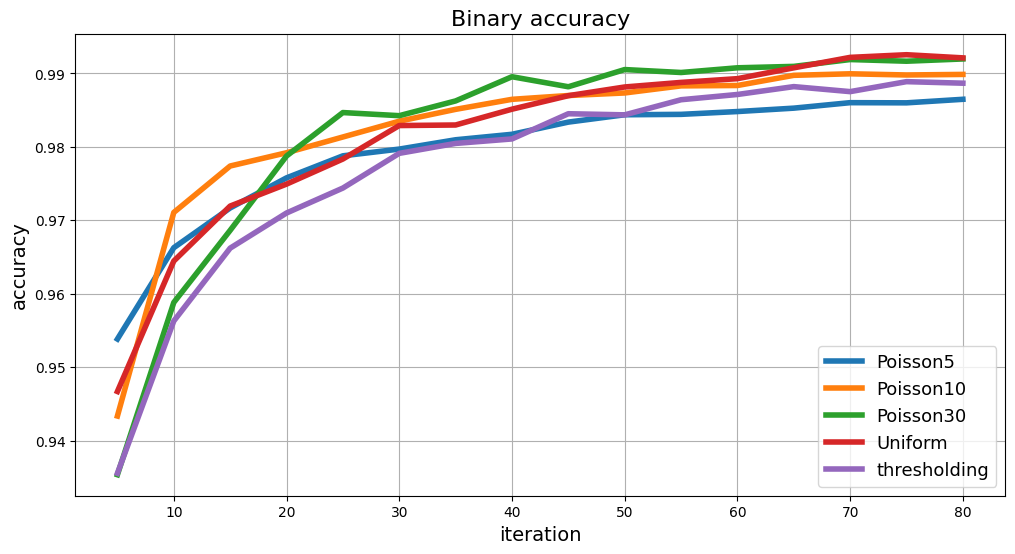

In [10]:
plt.figure(figsize=(12, 6))

for k, v in acc_results_summary.items():
    plt.plot(iterations, v, label=k, lw=4)
    
plt.title('Binary accuracy', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()

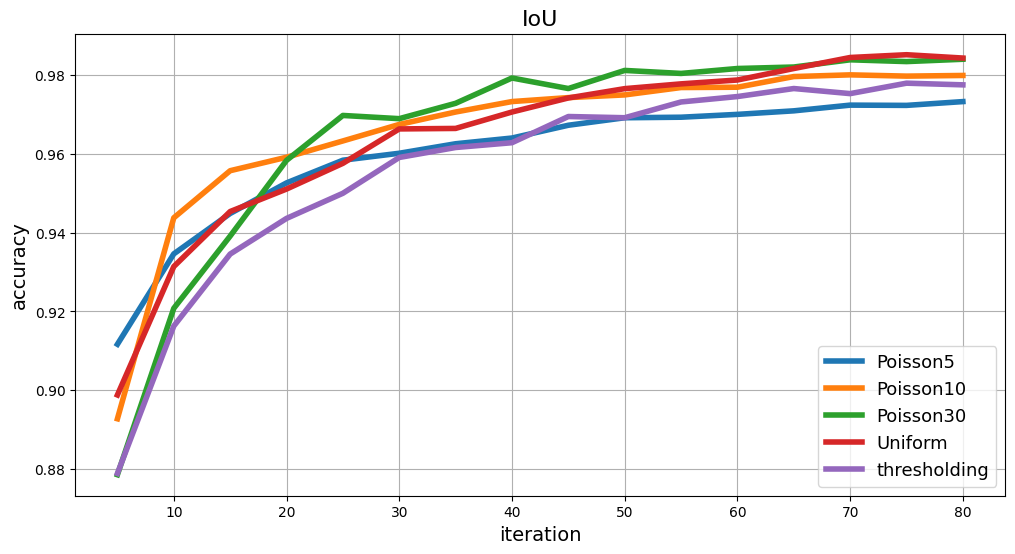

In [11]:
plt.figure(figsize=(12, 6))

for k, v in iou_results_summary.items():
    plt.plot(iterations, v, label=k, lw=4)
    
plt.title('IoU', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()

In [12]:
 # the paper only reported interation = 5, 10, 15, 20, 30, 40, 50, 60, 80
paper_acc_result = {'Poisson5':[95.8, 97.3, 97.7, 97.9, 98.2, 98.4, 98.5, 98.6, 98.7],
                'Poisson10':[95.4, 97.6, 98.1, 98.4, 98.7, 98.9, 99.0, 99.0, 99.0],
                'Poisson30':[92.7, 96.3, 97.8, 98.5, 99.0, 99.2, 99.4, 99.5, 99.6],
                'Uniform':[94.7, 96.8, 97.7, 98.2, 98.7, 99.0, 99.3, 99.4, 99.6],
                'thresholding': [92.9, 95.4, 96.5, 97.1, 97.7, 98.1, 98.4, 98.6, 98.9]}
paper_iou_result = {'Poisson5':[92.0, 94.7, 95.4, 96.0, 96.5, 96.9, 97.1, 97.3, 97.4],
                'Poisson10':[91.1, 95.3, 96.4, 96.9, 97.4, 97.8, 98.0, 98.0, 98.1],
                'Poisson30':[86.4, 92.9, 95.7, 97.0, 98.1, 98.5, 98.8, 99.0, 99.2],
                'Uniform':[90.0, 93.9, 95.5, 96.4, 97.5, 98.1, 98.6, 98.8, 99.2],
                'thresholding': [86.8, 91.2, 93.3, 94.3, 95.6, 96.3, 96.8, 97.3, 97.9]}

In [13]:
reported_idx = [0,1,2,3,5,7,9,11,15]

In [14]:
# error
for k in acc_results_summary.keys():
    print(k+": Acc_error_rate: ")
    print(np.round(np.abs(np.array(acc_results_summary[k])[reported_idx] - np.array(paper_acc_result[k])/100)/(np.array(paper_acc_result[k])/100), 4))
for k in iou_results_summary.keys():
    print(k+": IoU_error_rate: ")
    print(np.round(np.abs(np.array(iou_results_summary[k])[reported_idx] - np.array(paper_iou_result[k])/100)/(np.array(paper_iou_result[k])/100), 4))

Poisson5: Acc_error_rate: 
[0.0043 0.0069 0.0054 0.0033 0.0023 0.0023 0.0006 0.0012 0.0005]
Poisson10: Acc_error_rate: 
[0.0112 0.005  0.0037 0.0049 0.0035 0.0025 0.0027 0.0017 0.0001]
Poisson30: Acc_error_rate: 
[0.009  0.0043 0.0096 0.0063 0.0058 0.0025 0.0035 0.0042 0.004 ]
Uniform: Acc_error_rate: 
[0.0003 0.0037 0.0052 0.0072 0.0041 0.0049 0.0049 0.0047 0.0039]
thresholding: Acc_error_rate: 
[0.0071 0.0024 0.0013 0.     0.0022 0.0001 0.0004 0.0012 0.0003]
Poisson5: IoU_error_rate: 
[0.0091 0.0131 0.0096 0.0077 0.005  0.0051 0.0019 0.003  0.0007]
Poisson10: IoU_error_rate: 
[0.0201 0.0097 0.0086 0.0102 0.0067 0.0048 0.0051 0.0031 0.0011]
Poisson30: IoU_error_rate: 
[0.0168 0.0088 0.0187 0.012  0.0123 0.0058 0.0069 0.0084 0.008 ]
Uniform: IoU_error_rate: 
[0.0014 0.0081 0.0101 0.0134 0.0089 0.0106 0.0096 0.0093 0.0077]
thresholding: IoU_error_rate: 
[0.0125 0.0047 0.0017 0.0007 0.0032 0.0002 0.0012 0.0016 0.0015]
